## 1. 데이터 준비

In [1]:
import shap
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mlp
import matplotlib.pyplot as plt
from IPython.display import HTML
from sklearn.tree import plot_tree
from imblearn.pipeline import Pipeline
from pandas.io.formats.style import Styler
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.base import BaseEstimator, clone, TransformerMixin
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from category_encoders import CountEncoder, OneHotEncoder, OrdinalEncoder
from imblearn.ensemble import BalancedBaggingClassifier, RUSBoostClassifier
from sklearn.inspection import DecisionBoundaryDisplay, PartialDependenceDisplay
from sklearn.model_selection import cross_validate, LearningCurveDisplay, train_test_split, ValidationCurveDisplay
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, precision_score, PrecisionRecallDisplay, roc_auc_score, recall_score, RocCurveDisplay

%matplotlib inline

C:\Users\medici\miniconda3\envs\ai\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
accept = pd.read_csv("accepted_2007_to_2018Q4.csv", low_memory=False)

In [7]:
accept[target].unique()

array(['Fully Paid', 'Current', 'Charged Off', 'In Grace Period',
       'Late (31-120 days)', 'Late (16-30 days)', 'Default', nan,
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

In [8]:
accept[target].value_counts()

loan_status
Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: count, dtype: int64

In [10]:
accept[[target]]

TypeError: no numeric data to plot

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'Fully Paid'),
  Text(1, 0, 'Current'),
  Text(2, 0, 'Charged Off'),
  Text(3, 0, 'In Grace Period'),
  Text(4, 0, 'Late (31-120 days)'),
  Text(5, 0, 'Late (16-30 days)'),
  Text(6, 0, 'Default'),
  Text(7, 0, 'Does not meet the credit policy. Status:Fully Paid'),
  Text(8, 0, 'Does not meet the credit policy. Status:Charged Off')])

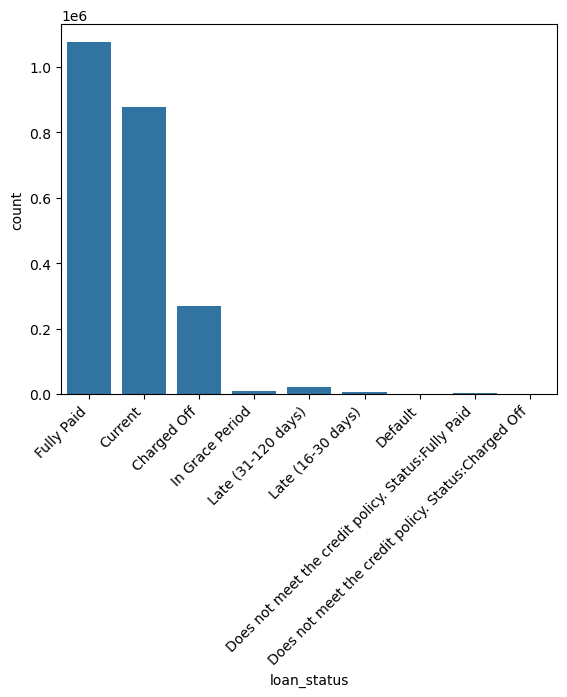

In [14]:
sns.countplot(accept, x=target)
plt.xticks(rotation=45, ha='right' )

In [3]:
select_features = ["loan_amnt", "term", "int_rate", "sub_grade", 
                   "verification_status", "addr_state", "dti", "open_acc", "revol_util", 
                   "total_acc", "last_fico_range_high", "last_fico_range_low", "avg_cur_bal", "mo_sin_old_rev_tl_op", 
                   "mo_sin_rcnt_rev_tl_op", "pct_tl_nvr_dlq"]

target = "loan_status"

In [16]:
raw_data = accept[(accept.loan_status == "Charged Off") & (accept.application_type == "Individual") | (accept.loan_status == "Fully Paid") & (accept.application_type == "Individual")]
data = raw_data[select_features + [target]].dropna()

In [18]:
data.shape

(1251098, 17)

In [19]:
data[target].value_counts()

loan_status
Fully Paid     999364
Charged Off    251734
Name: count, dtype: int64

In [5]:
raw_data.shape

(1319510, 151)

In [6]:
raw_data[target].value_counts()

loan_status
Fully Paid     1057295
Charged Off     262215
Name: count, dtype: int64

In [20]:
raw_data[target].value_counts() / len(raw_data)

loan_status
Fully Paid     0.801279
Charged Off    0.198721
Name: count, dtype: float64

In [17]:
data[target].value_counts() / len(data)

loan_status
Fully Paid     0.802894
Charged Off    0.197106
Name: count, dtype: float64

In [20]:
# 타겟 변수의 각 범주의 빈도 계산
target_counts = data[target].value_counts()

# 전체 데이터의 수 계산
total_samples = len(data)

# 각 범주의 비율 계산
target_ratios = target_counts / total_samples

print(target_ratios)


labels=['상환', '미상환']
sizes=target_ratios.values

loan_status
Fully Paid     0.79879
Charged Off    0.20121
Name: count, dtype: float64


In [23]:
plt.rcParams['font.family'] = 'NanumGothic'

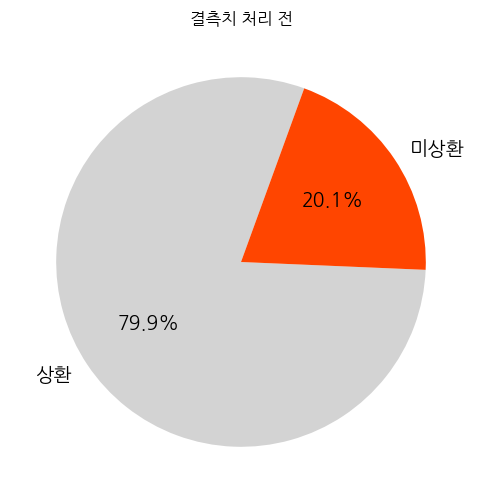

In [24]:
# 파이 차트 그리기
plt.figure(figsize=(6, 6))  
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['lightgray','orangered'], startangle=70, textprops={'fontsize': 14})  # autopct는 퍼센트를 소수점 1자리까지 표시하는 설정
plt.title('결측치 처리 전') 
plt.show()

### 1-1. 이상치 삭제

1. dti의 값이 0보다 작거나 40보다 큰 행
2. revol_util의 값이 100보다 큰 행
3. last_fico_range_low의 값이 300보다 작은 행

In [5]:
# data[(data.dti < 0) | (data.dti > 40)] 
# dti의 값이 0보다 작거나 40보다 큰 행 -> 1608행 전체 데이터의 0.14%

In [6]:
# data[data.revol_util > 100]
# revol_util의 값이 100보다 큰 행 -> 4402행 전체 데이터의 0.37%

In [30]:
data[(data.dti < 0) | (data.dti > 40)] 

1251098

In [32]:
len(data[data.revol_util > 100]) / data.revol_util

0.0036855626018105696

In [7]:
# data[data.last_fico_range_low < 300]
# last_fico_range_low의 값이 300보다 작은 행 -> 31690행 데이터셋의 2.69%

In [33]:
drop_rows = np.unique(np.concatenate((data[(data.dti < 0) | (data.dti > 40)].index, 
                                      data[data.revol_util > 100].index, 
                                      data[data.last_fico_range_low < 300].index, ))) # 중복제외 총 37486행 데이터셋의 3.18%

In [21]:
use_data[target].value_counts()

loan_status
Fully Paid     937812
Charged Off    203111
Name: count, dtype: int64

In [34]:
use_data = data.drop(index=drop_rows)

In [36]:
use_data.shape

(1210880, 17)

In [39]:
use_data[target].value_counts() / use_data.shape[0]

loan_status
Fully Paid     0.818041
Charged Off    0.181959
Name: count, dtype: float64

In [11]:
# use_data.loan_status.value_counts()

In [28]:
EDA = use_data.copy()

In [12]:
# use_data.loan_status.value_counts(normalize=True)

### 1-2. 훈련, 테스트 세트 분할

In [27]:
X, y = use_data.loc[:, [column for column in use_data.columns if column != target]], use_data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=6, stratify=y)

In [14]:
le = LabelEncoder()
le.fit(y_train)
le.classes_ = le.classes_[::-1]
y_train_transformed = pd.Series(le.transform(y_train), index=X_train.index, name=target)
y_test_transformed = pd.Series(le.transform(y_test), index=X_test.index, name=target)

In [15]:
def get_score_df(score_dict, caption):
    socre_df = pd.DataFrame.from_dict({key: np.append(value, value.mean()) for key, value in score_dict.items()}, orient="index", columns=["Fold_1", "Fold_2", "Fold_3", "Fold_4", "Fold_5", "Mean"]).loc[["train_roc_auc", "test_roc_auc", "train_recall", "test_recall", "fit_time", "score_time"], :].set_axis(pd.MultiIndex([["ROC_AUC", "RECALL", "시간 (Second)"], ["훈련", "검증"]], [[0, 0, 1, 1, 2, 2], [0, 1, 0, 1, 0, 1]]))
    return Styler(socre_df, precision=4, caption=f"{caption} 모델 Cross Validate").highlight_max((pd.IndexSlice[["ROC_AUC", "RECALL"], "검증"], ["Fold_1", "Fold_2", "Fold_3", "Fold_4", "Fold_5", "Mean"]), color="#1F77B4", axis=1).highlight_min((pd.IndexSlice[["ROC_AUC", "RECALL"], "검증"], ["Fold_1", "Fold_2", "Fold_3", "Fold_4", "Fold_5", "Mean"]), color="#FF7F0E", axis=1)

def get_feature_importance(model, X, y, onehot_features=None):
    clone_model = clone(model)
    clone_model.fit(X, y)
    if onehot_features:
        base_importance = pd.DataFrame(clone_model.feature_importances_, index=pd.Index(clone_model.feature_names_in_, name="feature"), columns=["feature_importances"])
        one_hot_importance = pd.DataFrame([base_importance[base_importance.index.str.match("|".join(onehot_features))].sum()], index=onehot_features, columns=["feature_importances"])
        feature_importance = pd.concat((base_importance.loc[~base_importance.index.str.match("|".join(onehot_features)), :], one_hot_importance)).sort_values("feature_importances", ascending=False)
    else:
        feature_importance = pd.DataFrame(clone_model.feature_importances_, index=pd.Index(clone_model.feature_names_in_, name="feature"), columns=["feature_importances"]).sort_values("feature_importances", ascending=False)
    fig, ax = plt.subplots(figsize=(23, 10))
    sns.barplot(feature_importance, x="feature_importances", y=feature_importance.index, ax=ax)
    [ax.text(patch.get_width() + 0.005, patch.get_y() + 0.5, f"{patch.get_width():.4f}") for patch in ax.patches]
    plt.show()
    return

## 2. 전처리

1. 순서형 특성인 sub_grade, emp_length에 대해서 OrdinalEncoder 사용
2. cadinality가 상대적으로 높은 addr_state특성은 CountEncoder 사용
3. loan_amnt(대출금), int_rate(이자율) 및 term(기간)에 대해 installment(월 원리금)를 직접 계산하여 사용
4. 현재 활성화 되어있는 계좌 수 open_acc와 총 계좌수 total_acc를 공학하여, 현재 활성화 되어있는 계좌 비율인 open_acc_rate 생성

In [16]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy["term"] = X_copy.term.str.extract("(\d+)").astype(np.float64)
        X_copy["open_acc_rate"] = (X_copy.open_acc / X_copy.total_acc * 100).round(1)
        X_copy["last_fico_score"] = X_copy[["last_fico_range_low", "last_fico_range_high"]].mean(axis=1).round()
        X_copy["installment"] = np.vectorize(lambda x, y, z: round((x * y * 0.01 / 12) * ((1 + y * 0.01 / 12) ** z) / (((1 + y * 0.01 / 12) ** z) - 1), 2))(X_copy.loan_amnt, X_copy.int_rate, X_copy.term)
        X_copy = X_copy.drop(["open_acc", "total_acc", "last_fico_range_low", "last_fico_range_high"], axis=1)
        return X_copy

In [17]:
preprocessing = Pipeline([("ordinal_encoder", OrdinalEncoder(mapping=[{"col": "sub_grade", 
                                                                       "mapping": {"F5": 0, "F4": 1, "F3": 2, "F2": 3, "F1": 4, 
                                                                                   "E5": 5, "E4": 6, "E3": 7, "E2": 8, "E1": 9, 
                                                                                   "D5": 10, "D4": 11, "D3": 12, "D2": 13, "D1": 14, 
                                                                                   "C5": 15, "C4": 16, "C3": 17, "C2": 18, "C1": 19, 
                                                                                   "B5": 20, "B4": 21, "B3": 22, "B2": 23, "B1": 24, 
                                                                                   "A5": 25, "A4": 26, "A3": 27, "A2": 28, "A1": 29}}, 
                                                                      {"col": "emp_length", 
                                                                       "mapping": {"< 1 year": 0, "1 year": 1, "2 year": 2, "3 year": 3, "4 year": 4, 
                                                                                   "5 year": 5, "6 year": 6, "7 year": 7, "8 year": 8, "9 year": 9, "10+ years": 10}}], 
                                                             cols=["sub_grade", "emp_length"])), 
                          ("count_encoder", CountEncoder(cols=["addr_state"])), 
                          ("onehot_encoder", OneHotEncoder(cols=["verification_status"], use_cat_names=True)), 
                          ("feature_engineer", FeatureEngineer()), 
                          ("under_resample", RandomUnderSampler(random_state=6))])

## 3. 베이스라인 모델

In [18]:
base_model = DecisionTreeClassifier(random_state=6)

In [19]:
X_train_preprocessed, y_train_preprocessed = preprocessing.fit_resample(X_train, y_train_transformed)
X_test_preprocessed, y_test_preprocessed = preprocessing[:4].transform(X_test), y_test_transformed

In [20]:
score_dict = cross_validate(base_model, X_train_preprocessed, y_train_preprocessed, scoring=["roc_auc", "recall"], n_jobs=-1, return_train_score=True)

### 3-1. 모델 평가

In [21]:
get_score_df(score_dict, "베이스라인")

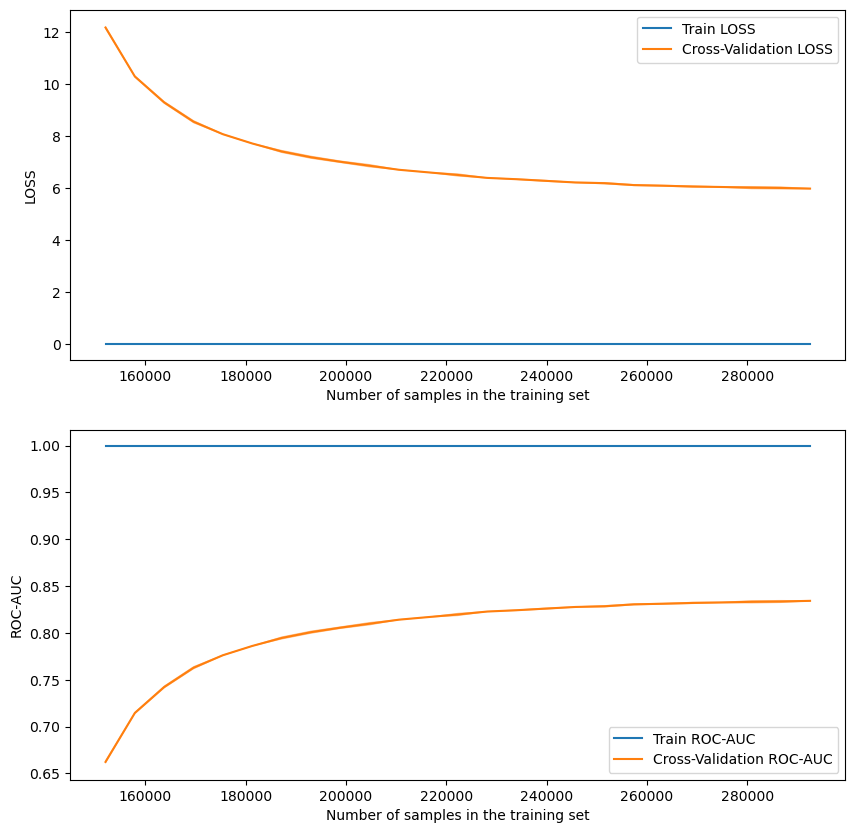

In [22]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
LearningCurveDisplay.from_estimator(base_model, X_train_preprocessed, y_train_preprocessed, train_sizes=np.linspace(0.02, 1, 50), scoring="neg_log_loss", n_jobs=-1, random_state=6, ax=ax[0], negate_score=True, score_name="LOSS")
LearningCurveDisplay.from_estimator(base_model, X_train_preprocessed, y_train_preprocessed, train_sizes=np.linspace(0.02, 1, 50), scoring="roc_auc", n_jobs=-1, random_state=6, ax=ax[1], score_name="ROC-AUC")
ax[0].legend(["Train LOSS", "Cross-Validation LOSS"])
ax[1].legend(["Train ROC-AUC", "Cross-Validation ROC-AUC"])
plt.show()

#### 결론

* 모든 폴드의 훈련 세트에 대한 ROC-AUC 점수가 1.00으로 완벽한 성능을 보이는 반면, 검증 세트의 ROC-AUC 점수가 평균 0.83으로 비교적 낮은 성능을 보입니다. 이러한 상황에서 모델이 훈련 데이터에 너무 과대적합되었을 가능성이 있습니다.
* 학습곡선(learning curve)를 확인한 결과, 데이터가 늘어감에 따라 일정 데이터 개수 미만에서는 LOSS가 감소하고 ROC-AUC가 증가하는 것을 확인할 수 있었습니다. 그러나 데이터 수가 계속 늘어나도 훈련 세트와 검증 세트 간의 손실과 ROC-AUC의 차이가 더 이상 줄어들지 않고 일정한 오차를 보이는 것으로 나타났습니다.
* 이러한 결과를 통해 모델이 훈련 세트에 너무 적합하게 되어 새로운 데이터에 대한 일반화 성능이 저하되는 과대적합(over-fitting)이라 판단하였습니다.

## 4. 하이퍼파라미터 튜닝 진행

|매개변수|설명|값|
|--|--|--|
|criterion|노드의 분할 기준|default: "gini" or "entropy" or "log_loss"|
|splitter|노드를 분할하는 전략|default: "best" or "random"|
|max_depth|결정 트리의 최대 깊이|default: None (제한 없음)|
|min_samples_split|노드를 분할하기 위한 최소 샘플 수|default: 2|
|min_samples_leaf|리프 노드에 필요한 최소 샘플 수|default: 1|
|min_weight_fraction_leaf|가중치가 부여된 샘플의 비율로 최소 리프 노드 샘플 수|default: 0.0|
|max_features|각 분할에서 고려할 최대 특성 수|default: None (제한 없음)|
|random_state|무작위성을 제어하기 위한 시드 값|default: None|
|max_leaf_nodes|리프 노드의 최대 개수|default: None (제한 없음)|
|min_impurity_decrease|분할을 수행할 최소 불순도 감소|default: 0.0|
|class_weight|클래스에 대한 가중치|default: None or "balanced"|
|ccp_alpha|비용 복잡성 가지치기에 사용되는 비용 복잡성 매개변수|default: 0.0|
|monotonic_cst|단조적인 특성에 사용되는 부분 의사 결정 트리의 상수값|default: None|

max_depth: 결정 트리의 최대 깊이를 제한하여 과대적합을 줄입니다. 트리의 깊이가 깊어질수록 모델은 훈련 데이터에 더 적합해지지만, 테스트 데이터에 대한 일반화 성능이 저하될 수 있습니다. 적절한 최대 깊이를 설정하면 모델이 더 간단해지고 일반화 성능이 향상될 수 있습니다.

min_samples_split: 노드를 분할하기 위해 필요한 최소 샘플 수를 지정하여, 더 이상 분할하지 않는 작은 노드를 생성함으로써 과대적합을 줄입니다.

min_samples_leaf: 리프 노드가 가져야 하는 최소 샘플 수를 지정하여, 각 리프 노드의 크기를 제한함으로써 과대적합을 줄입니다.

max_features: 각 노드에서 분할에 사용할 수 있는 최대 특성 수를 제한함으로써 모델의 복잡성을 줄입니다. 적은 수의 특성을 사용하면 모델이 특성의 잡음에 민감하지 않게 될 수 있습니다.

과대적합을 최소화 하기 위해 max_depth, min_samples_split, min_samples_leaf, max_features의 하이퍼파라미터를 튜닝하고
어떤 노드 분할 기준이 적합한지 확인을 위해 criterion 튜닝

In [23]:
# 아래의 그리드를 사용하여 pycaret에서 진행
custom_grid={"criterion": ["gini", "entropy"], 
             "max_depth": np.arange(2, 20, 1), 
             "min_samples_split": np.arange(2, 100, 1), 
             "min_samples_leaf": np.arange(1, 100, 1), 
             "max_features": [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, "sqrt", "log2", None]}

In [24]:
tune_model = DecisionTreeClassifier(criterion="entropy", max_depth=7, min_samples_split=26, min_samples_leaf=18, random_state=6)

In [25]:
score_dict = cross_validate(tune_model, X_train_preprocessed, y_train_preprocessed, scoring=["roc_auc", "recall"], n_jobs=-1, return_train_score=True)

### 4-1. 모델 평가

In [26]:
get_score_df(score_dict, "튜닝")

#### 학습곡선 (Learning Curve) 확인

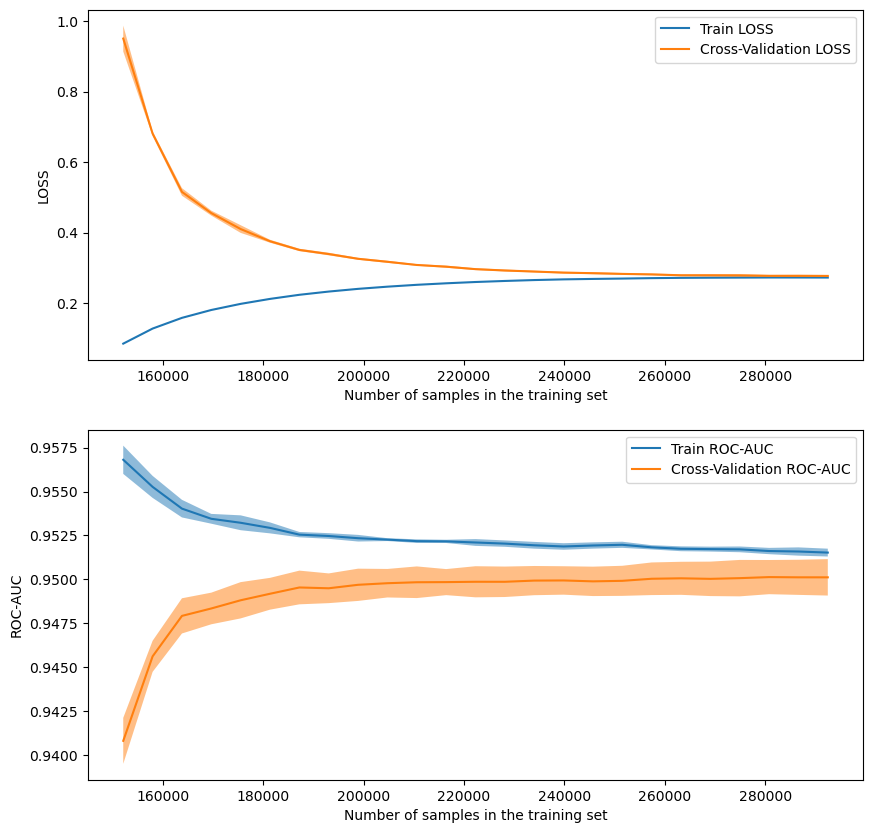

In [27]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
LearningCurveDisplay.from_estimator(tune_model, X_train_preprocessed, y_train_preprocessed, train_sizes=np.linspace(0.02, 1, 50), scoring="neg_log_loss", n_jobs=-1, random_state=6, ax=ax[0], negate_score=True, score_name="LOSS")
LearningCurveDisplay.from_estimator(tune_model, X_train_preprocessed, y_train_preprocessed, train_sizes=np.linspace(0.02, 1, 50), scoring="roc_auc", n_jobs=-1, random_state=6, ax=ax[1], score_name="ROC-AUC")
ax[0].legend(["Train LOSS", "Cross-Validation LOSS"])
ax[1].legend(["Train ROC-AUC", "Cross-Validation ROC-AUC"])
plt.show()

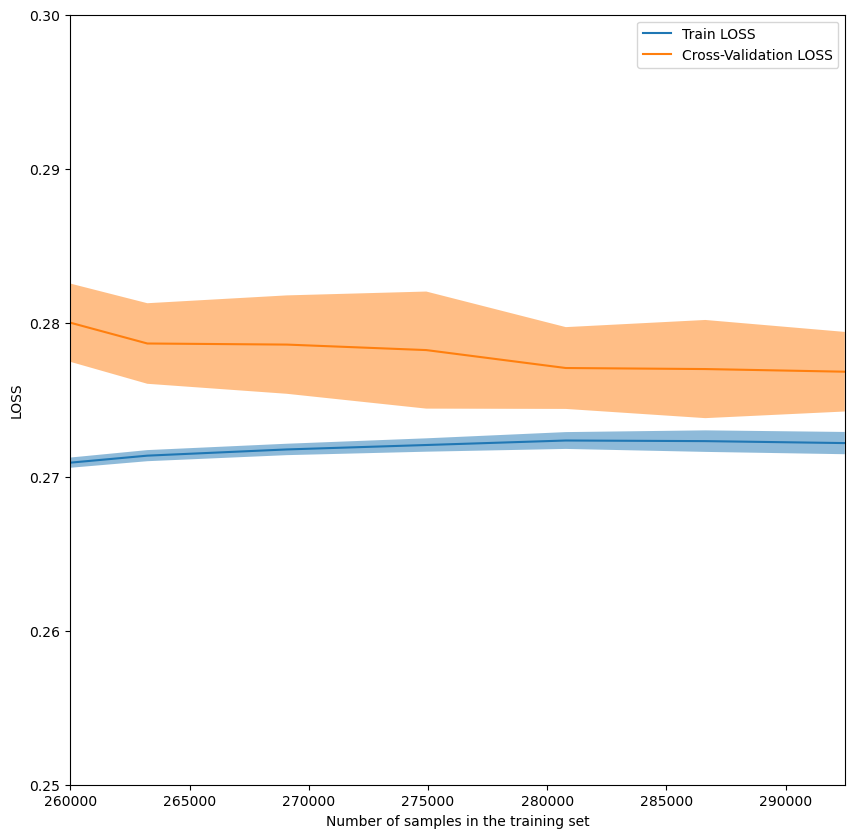

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
LearningCurveDisplay.from_estimator(tune_model, X_train_preprocessed, y_train_preprocessed, train_sizes=np.linspace(0.02, 1, 50), scoring="neg_log_loss", n_jobs=-1, random_state=6, ax=ax, negate_score=True, score_name="LOSS")
ax.legend(["Train LOSS", "Cross-Validation LOSS"])
ax.set_xlim(260000, 292500)
ax.set_ylim(0.25, 0.3)
plt.show()

##### 결론

* 훈련데이터의 샘플수가 증가할수록 LOSS와 ROC-AUC의 각 훈련, 검증점수의 격차가 감소하고 분산도 작아지며 값이 수렴하는것으로 보아, 해당 모델이 데이터에 잘 적합되고 일반화 되어있다는것을 알 수 있다.
* 데이터셋 전체가 아닌, 언더샘플링된 데이터 샘플수로 충분히 일정 수치에 수렴한다.

#### 검증곡선 (Validation Curve) 확인

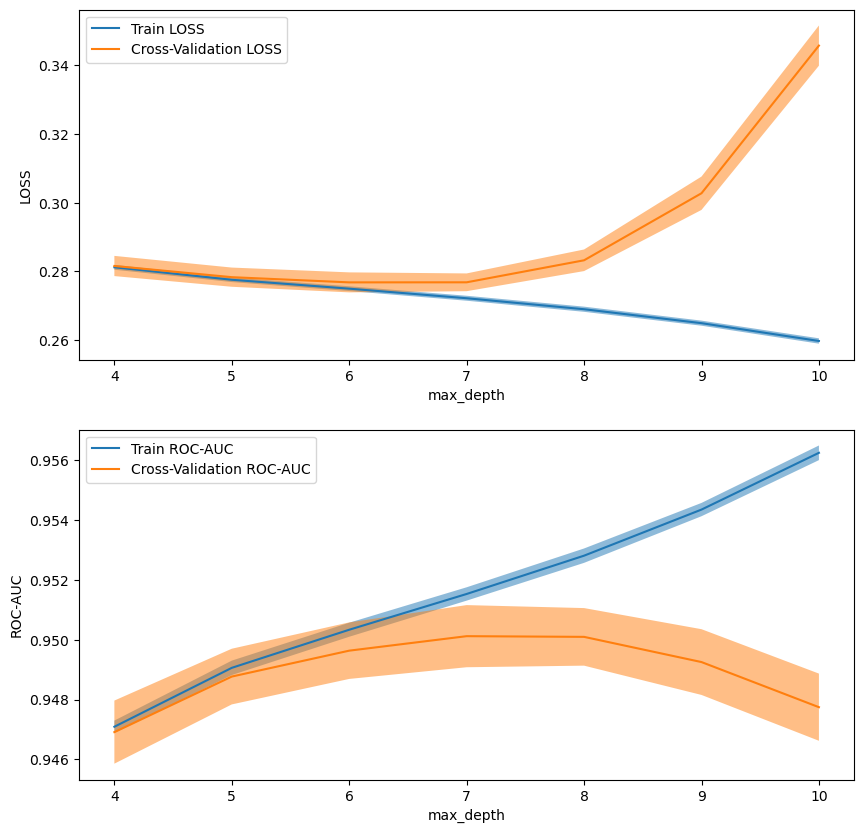

In [29]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ValidationCurveDisplay.from_estimator(tune_model, X_train_preprocessed, y_train_preprocessed, param_name="max_depth", param_range=[4, 5, 6, 7, 8, 9, 10], scoring="neg_log_loss", n_jobs=-1, ax=ax[0], negate_score=True, score_name="LOSS")
ValidationCurveDisplay.from_estimator(tune_model, X_train_preprocessed, y_train_preprocessed, param_name="max_depth", param_range=[4, 5, 6, 7, 8, 9, 10], scoring="roc_auc", n_jobs=-1, ax=ax[1], score_name="ROC-AUC")
ax[0].legend(["Train LOSS", "Cross-Validation LOSS"])
ax[1].legend(["Train ROC-AUC", "Cross-Validation ROC-AUC"])
plt.show()

##### 결론

* max_depth가 증가할수록 LOSS와 ROC-AUC의 오차가 증가하고, 6이하의 값에서 분산에 따라 과소적합되는 경향이 보여, max_depth가 7일때 최대성능을 가진다.

#### 혼동행렬 (Confusion Matrix) 확인

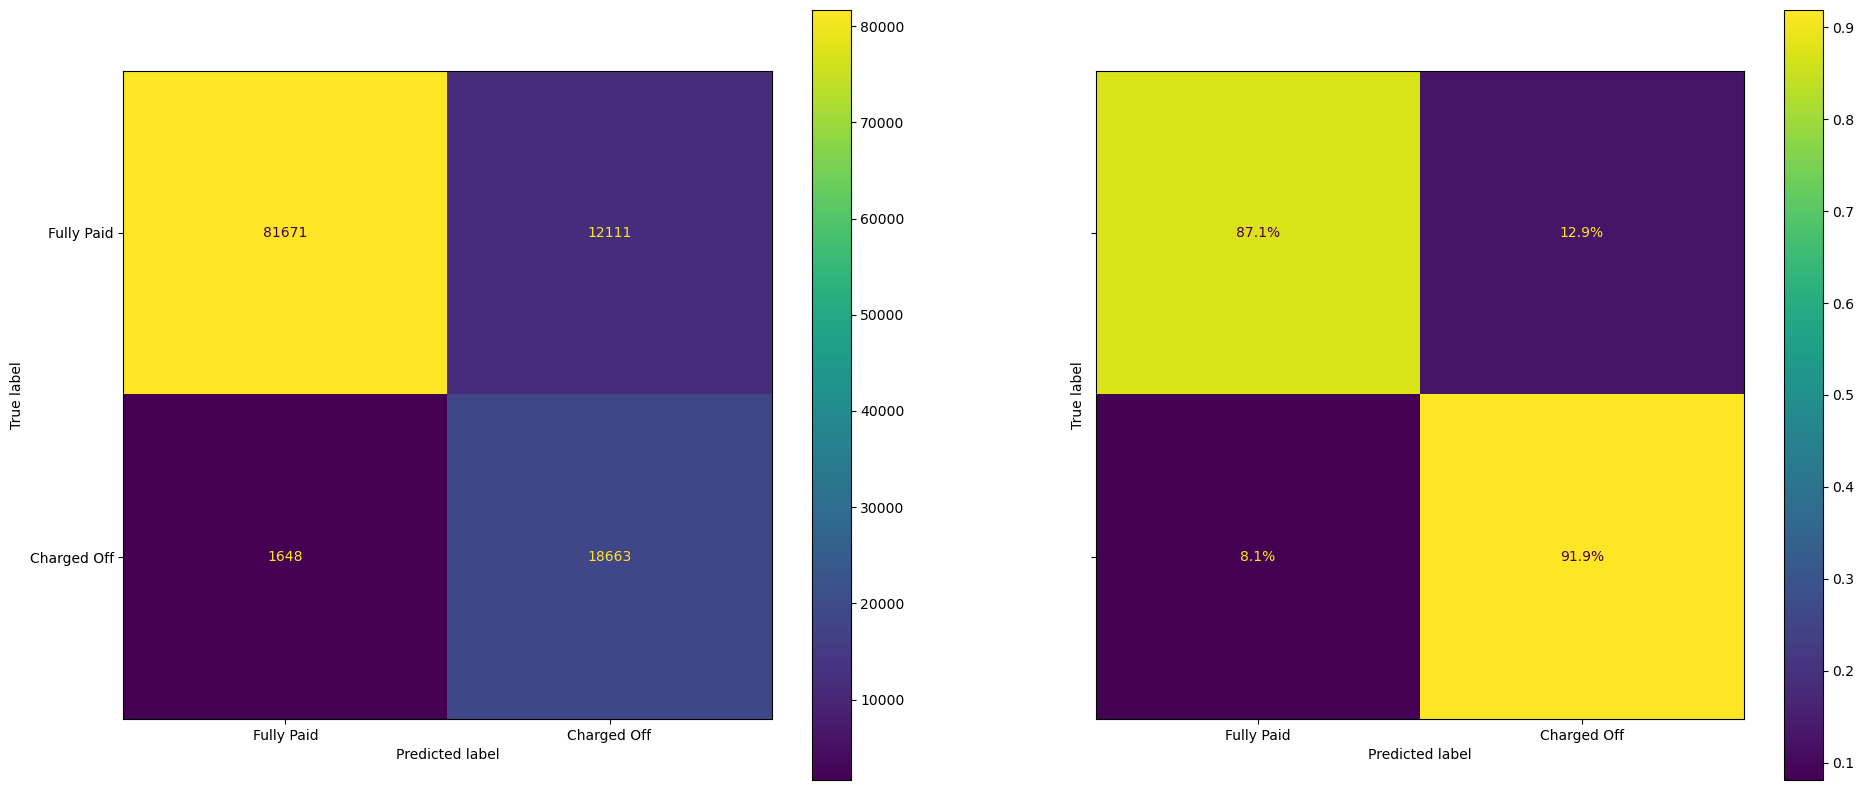

In [30]:
clone_tune_model = clone(tune_model)
clone_tune_model.fit(X_train_preprocessed, y_train_preprocessed)

fig, ax = plt.subplots(1, 2, figsize=(23, 10), sharey=True)
ConfusionMatrixDisplay.from_estimator(clone_tune_model, X_test_preprocessed, y_test_preprocessed, display_labels=["Fully Paid", "Charged Off"], values_format="d", ax=ax[0])
ConfusionMatrixDisplay.from_estimator(clone_tune_model, X_test_preprocessed, y_test_preprocessed, normalize="true", display_labels=["Fully Paid", "Charged Off"], values_format=".1%", ax=ax[1])
plt.show()

##### 결론

* 양성과 음성을 각각 약 90% 구분하므로, 클래스를 구분하는 능력이 충분하다.
* 프로젝트 목적과 맞게 양성 클래스를 구분하는 능력이 더 뛰어나다.

## 5. 모델 해석

### 5-1. 특성 중요도

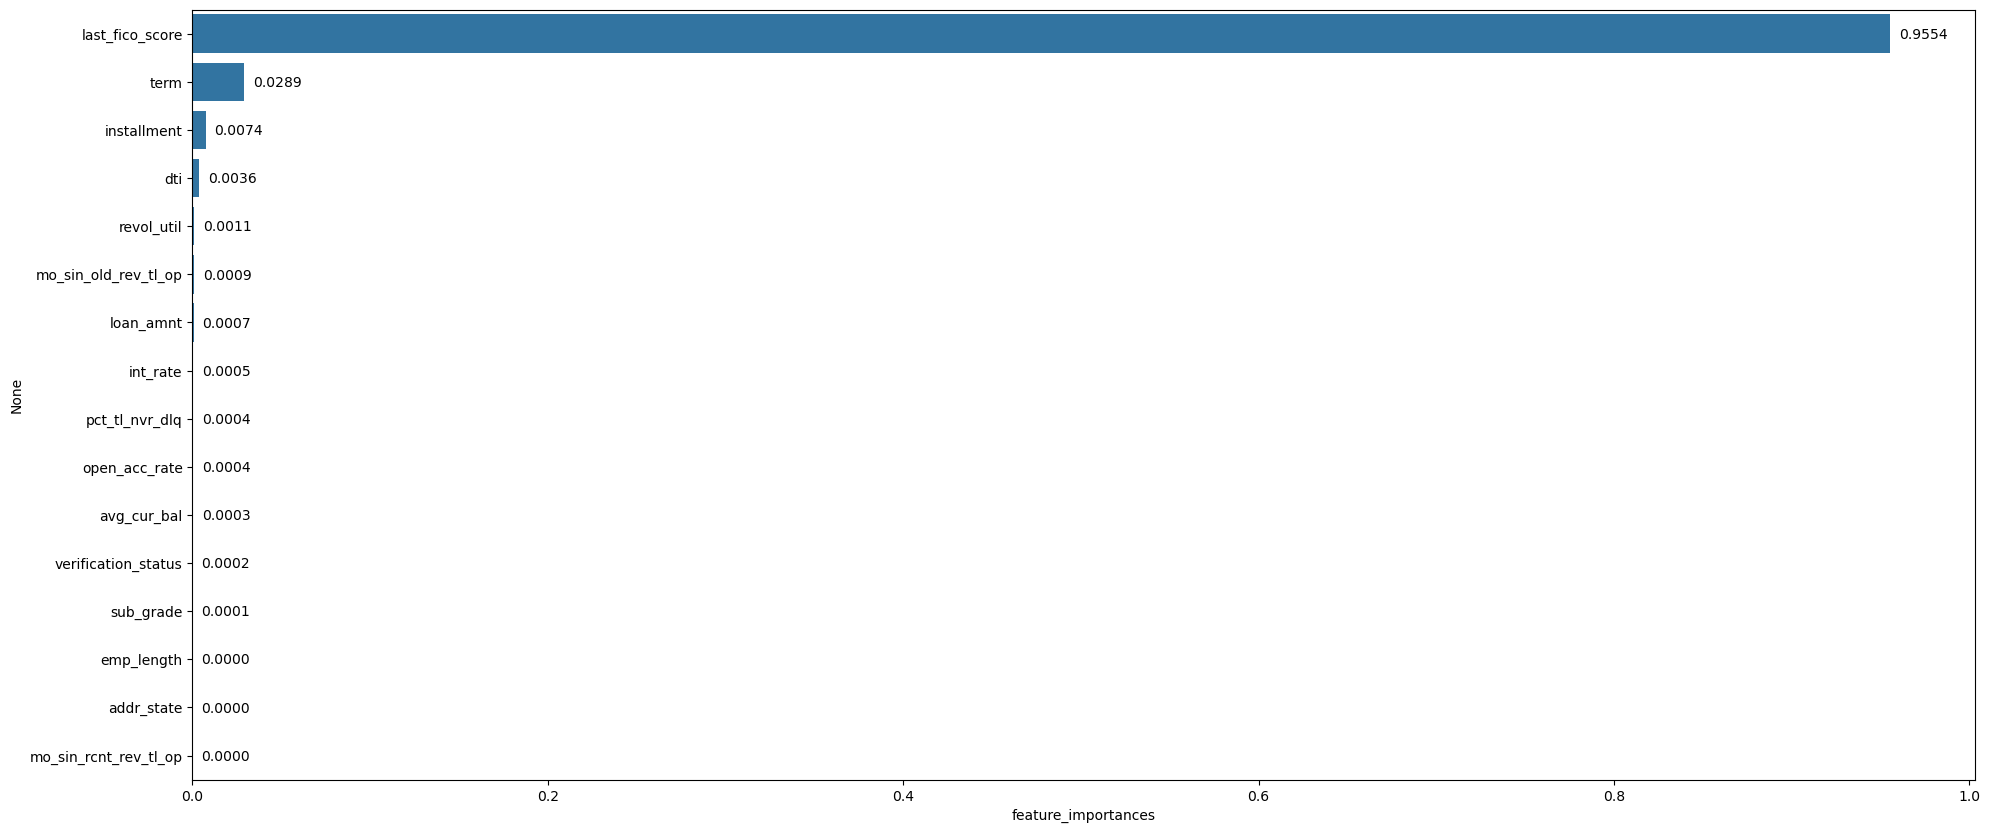

In [31]:
get_feature_importance(tune_model, X_train_preprocessed, y_train_preprocessed, ["verification_status"])

#### 결론

* last_fico_score가 예측에 가장 중요한 특성임을 알 수 있다.
* last_fico_score는 last_fico_high와 last_fico_low의 평균값으로, 대출자의 현재 신용점수에 대한 값이다.
* 신용점수는 개인의 재산상황, 채무상황, 신용카드 사용 패턴등 개인의 신용 이력을 종합적으로 평가하여 산출됩니다.
* 데이터에서 확인 가능한 여러가지 신용을 나타내는 특성들을 포괄적으로 계산하여 하나의 수치로 나타낸 값이기 때문에, 모델에서 예측에 가장 중요한 특성으로 사용된것으로 보입니다.

### 5-2. 부분 의존성 플롯

예측에 가장 중요한 특성에 대해서 확인

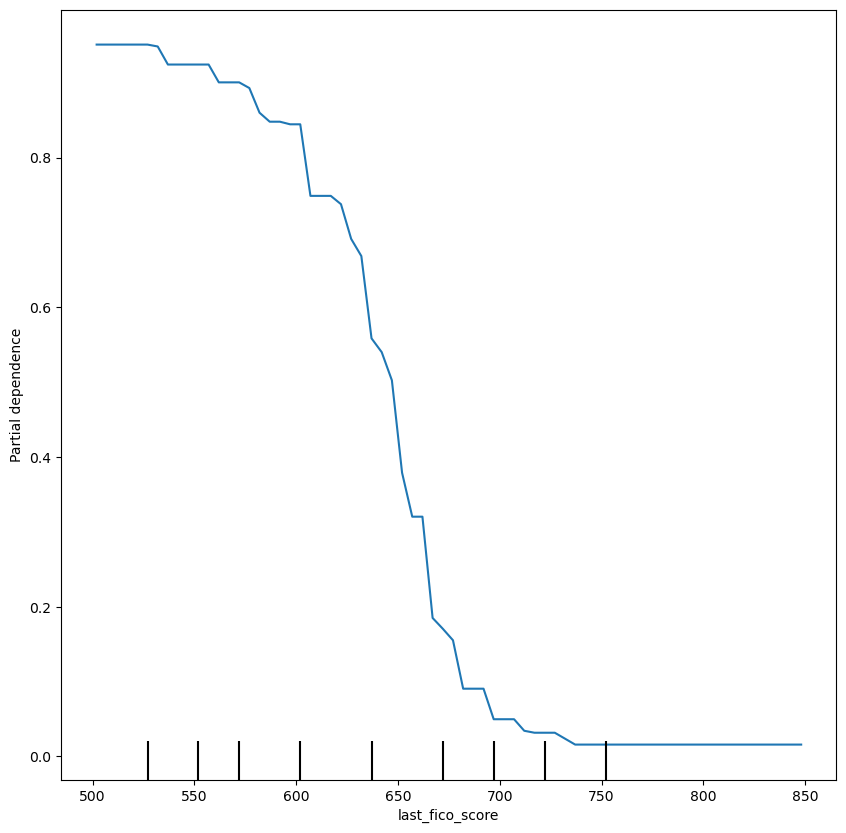

In [32]:
fig, ax = plt.subplots(figsize=(10, 10))
PartialDependenceDisplay.from_estimator(clone_tune_model, X_train_preprocessed, ["last_fico_score"], n_jobs=-1, ax=ax)
plt.show()

#### 결론

* last_fico_score에 대한 PDP가 시그모이드 함수의 대칭함수와 비슷한 모양으로 그려지는것으로 확인되어, 예측확률에 가장 큰 영향력을 주는것을 알 수 있다.
* last_fico_score가 작을수록 음성(Charged Off)일 확률이 높아진다.

### 5-3. 결정경계 시각화

#### last_fico_score와 다른 특성간 결정경계

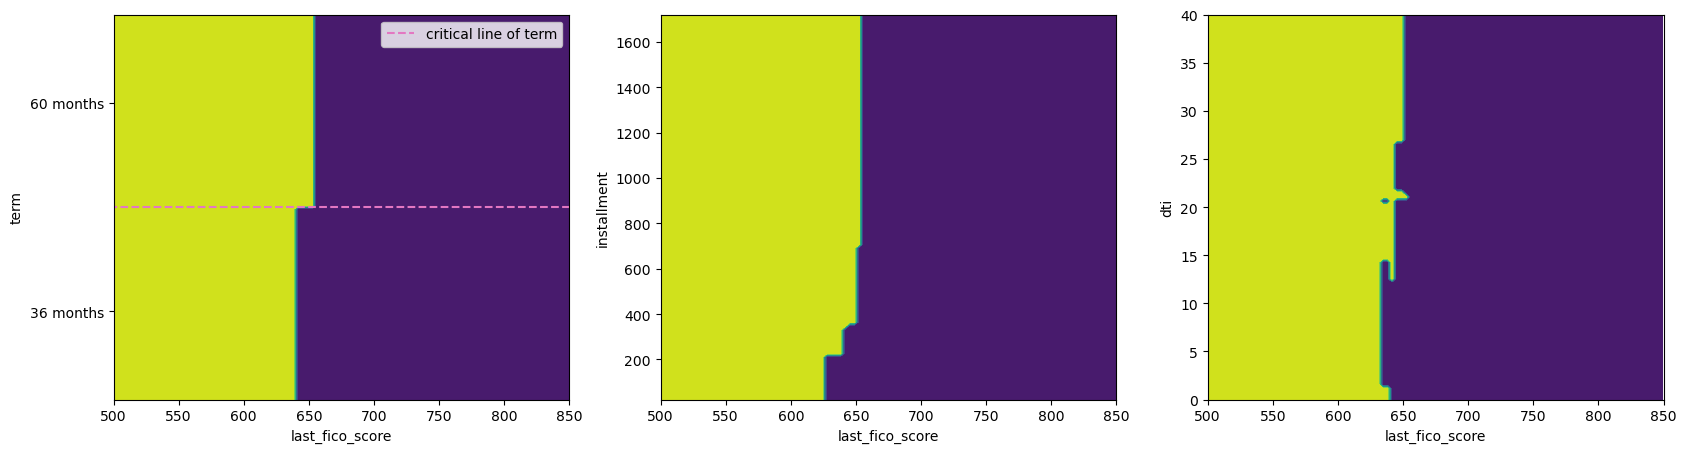

In [33]:
boundary_term = clone(tune_model)
boundary_term.fit(X_train_preprocessed[["last_fico_score", "term"]], y_train_preprocessed)
boundary_installment = clone(tune_model)
boundary_installment.fit(X_train_preprocessed[["last_fico_score", "installment"]], y_train_preprocessed)
boundary_dti = clone(tune_model)
boundary_dti.fit(X_train_preprocessed[["last_fico_score", "dti"]], y_train_preprocessed)

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
DecisionBoundaryDisplay.from_estimator(boundary_term, X_train_preprocessed[["last_fico_score", "term"]], plot_method="contourf", response_method="predict", ax=ax[0])
ax[0].hlines(48, 300, 850, colors="tab:pink", linestyles="dashed", label="critical line of term")
ax[0].set_yticks([41.5, 54.5], ["36 months", "60 months"])
ax[0].set_xticks([300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850], ["300", "350", "400", "450", "500", "550", "600", "650", "700", "750", "800", "850"])
ax[0].set_xlim(500, 850)
ax[0].set_ylim(36, 60)
ax[0].legend()
DecisionBoundaryDisplay.from_estimator(boundary_installment, X_train_preprocessed[["last_fico_score", "installment"]], plot_method="contourf", response_method="predict", ax=ax[1])
ax[1].set_xticks([300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850], ["300", "350", "400", "450", "500", "550", "600", "650", "700", "750", "800", "850"])
ax[1].set_xlim(500, 850)
ax[1].set_ylim(23.26, 1719.83)
DecisionBoundaryDisplay.from_estimator(boundary_dti, X_train_preprocessed[["last_fico_score", "dti"]], plot_method="contourf", response_method="predict", ax=ax[2])
ax[2].set_xticks([300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850], ["300", "350", "400", "450", "500", "550", "600", "650", "700", "750", "800", "850"])
ax[2].set_xlim(500, 850)
ax[2].set_ylim(0, 40)
plt.show()

##### 결론

* 대출기간 (term)이 길수록 Charged Off인 경향을 보인다.
* 월 원리금 (installment)가 높을수록 Charged Off인 경향을 보인다.
* 총부채상환비율 (dti)가 높을수록 Charged Off인 경향을 보인다.

### 5-4. 트리 시각화 - 선생님이 안보여줘도 될것같다 하셨음

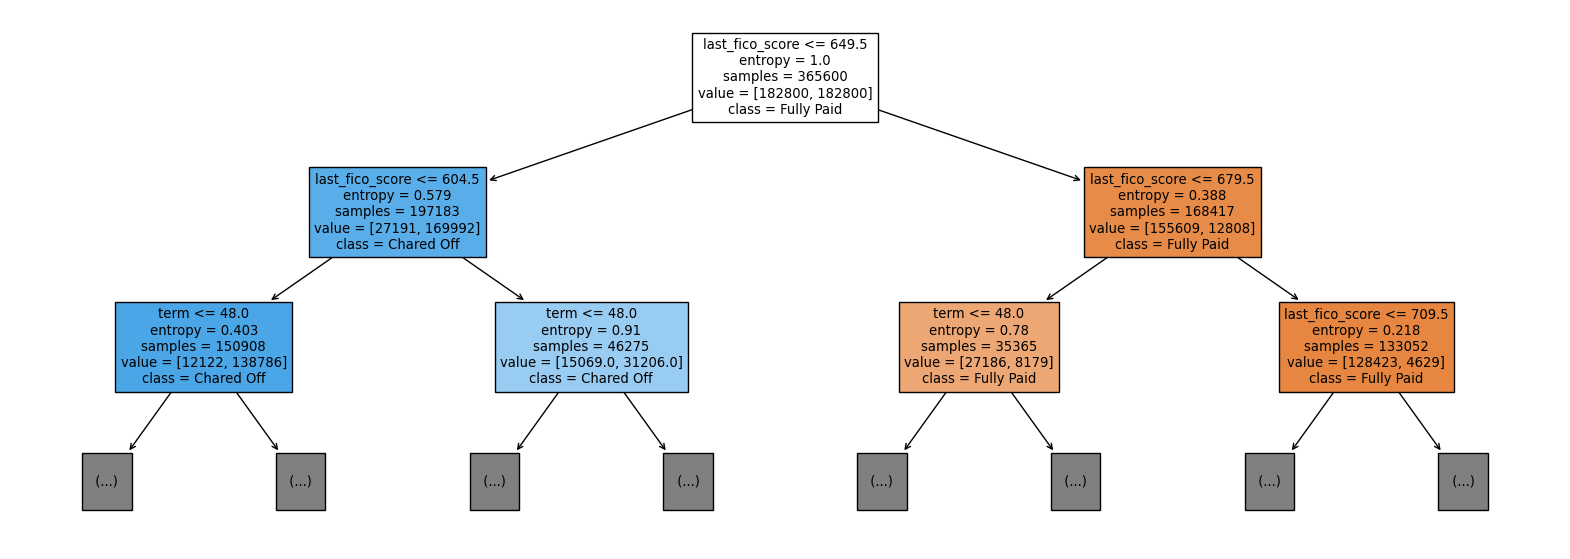

In [34]:
fig, ax = plt.subplots(figsize=(20, 7))
plot_tree(clone_tune_model, max_depth=2, feature_names=clone_tune_model.feature_names_in_, class_names=["Fully Paid", "Chared Off"], filled=True, ax=ax)
plt.show()

### 5-5. SHAP 그래프 확인

In [35]:
explainer = shap.TreeExplainer(clone_tune_model, feature_perturbation="tree_path_dependent")
shap_values = explainer.shap_values(X_test_preprocessed)

#### a. summery_plot을 사용한 특성별 shap value, 특성별 영향도 파악

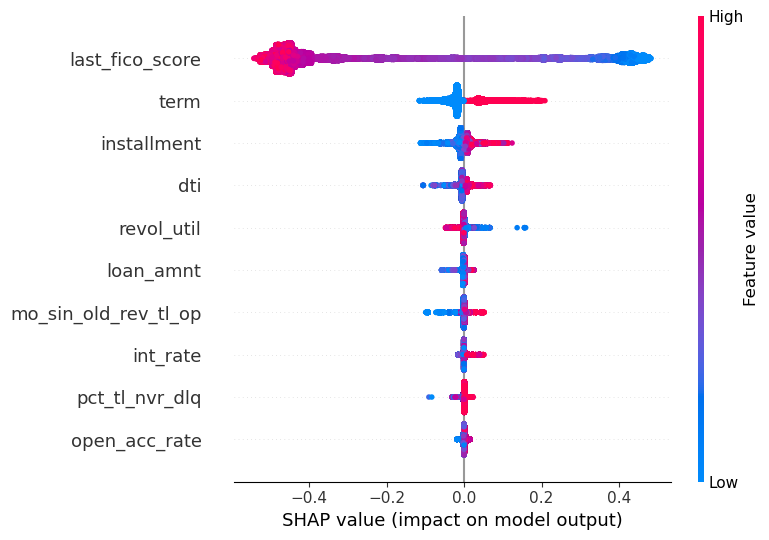

In [36]:
shap.summary_plot(shap_values[1], X_test_preprocessed, feature_names=X_test_preprocessed.columns.tolist(), max_display=10, class_names=["Fully Paid", "Charged Off"])

#### b. force_plot을 활용한 샘플링 데이터의 특성별 경향성 파악

In [37]:
force_plot = shap.force_plot(explainer.expected_value[1], shap_values[1][:2000, :], features=X_test_preprocessed.iloc[:2000, :], feature_names=X_test_preprocessed.columns.tolist())
HTML(f"<div style='background-color:white;'>{shap.getjs() + force_plot.html()}</div>")

#### 결론 (a, b)

* 대체적으로 최근신용점수(last_fico_score)가 낮아질수록 양성인 경향성을 보입니다. 예측값과 음의 상관성을 보이며, 특성들중 가장 영향력이 큰것으로 확인됩니다.
* 대출기간(term)이 짧을수록 음성, 길수록 양성인 경향성을 보입니다. 예측값과 양의 상관성을 보입니다.
* 월상환원리금(installment)가 작을수록 음성, 높을수록 양성인 경향성을 보입니다. 예측값과 양의 상관성을 보입니다.
* 총부채상환율(dti)가 작을수록 음성, 높을수록 양성인 경향성을 보입니다. 예측값과 양의 상관성을 보입니다.

#### c. 각 예측별 특성의 영향력 파악

##### 92번 인덱스 - id : 57951216 회원

* Charged Off 확률 상승에 긍정적인 영향을 준 요인은 installment, last_fico_score 이며, 부정적인 영향을 준 요인은 term, dti 입니다.
* 대출 기간(term)이 짧고, 낮은 dti가 양성에 부정적인 영향을 끼치지만, 높은 월 상환금(installment)와 평균보다 낮은 최근 신용점수(last_fico_socre)가 양성 확률에 더 큰 영향을 끼쳤다고 해석할 수 있습니다.

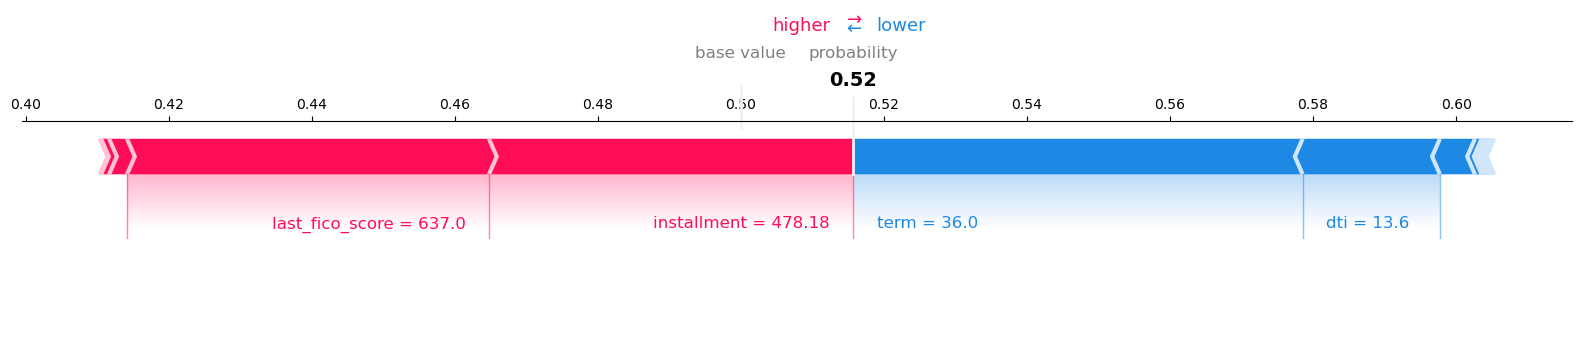

In [38]:
shap.force_plot(explainer.expected_value[1], shap_values[1][9, :], features=X_test_preprocessed.iloc[9, :], feature_names=X_test_preprocessed.columns.tolist(), out_names="probability", matplotlib=mlp)

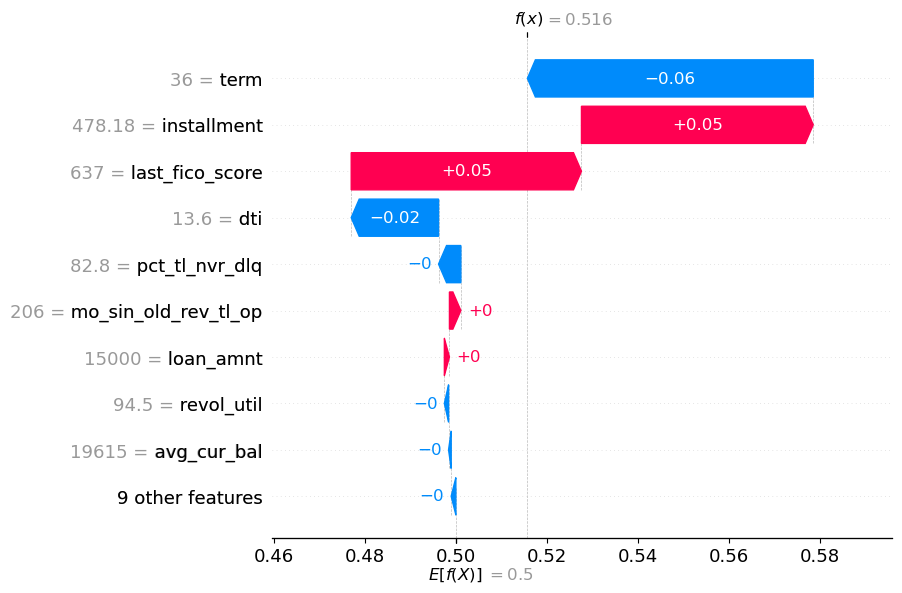

In [39]:
shap.waterfall_plot(shap.Explanation(values=shap_values[1][9, :], 
                                     base_values=explainer.expected_value[1], 
                                     data=X_test_preprocessed.iloc[9, :], 
                                     feature_names=X_test_preprocessed.columns))

##### 132번 인덱스 - id : 6568343 회원

* 대출기간(term)이 길어 양성에 긍정적인 영향을 끼치나, 다소 높은 최근 신용점수(last_fico_score)가 음성 확률에 큰 영향을 끼쳣다고 해석할 수 있습니다.

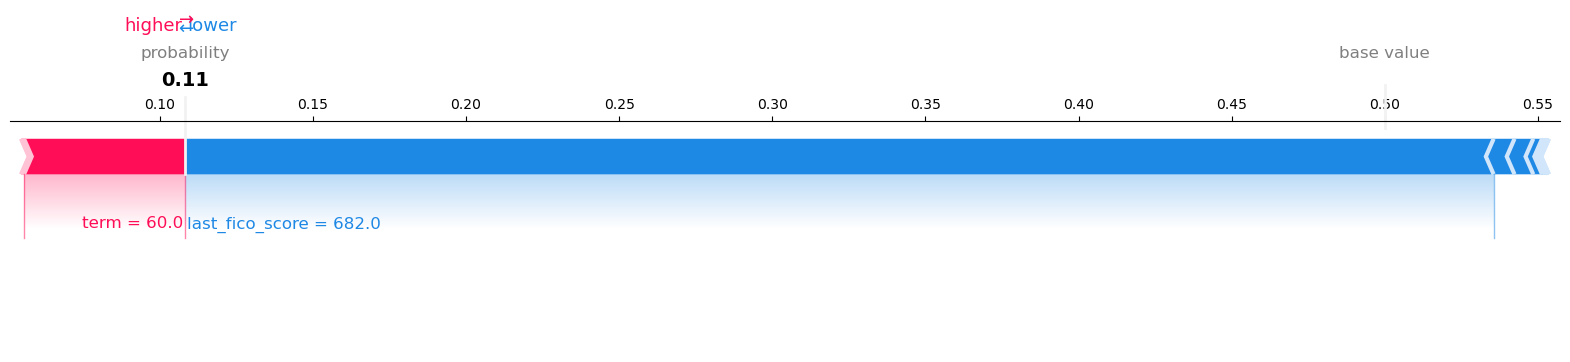

In [40]:
shap.force_plot(explainer.expected_value[1], shap_values[1][132, :], features=X_test_preprocessed.iloc[132, :], feature_names=X_test_preprocessed.columns.tolist(), out_names="probability", matplotlib=mlp)

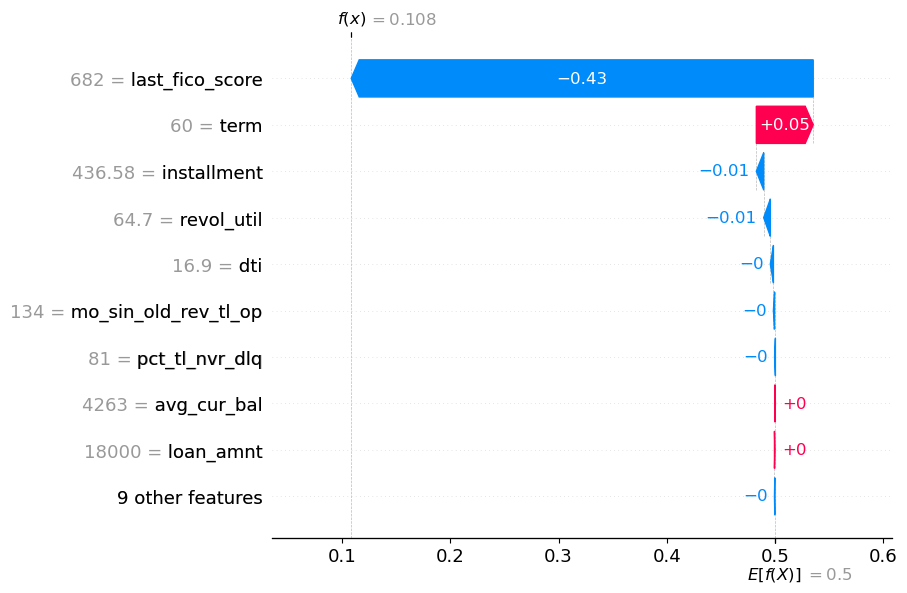

In [41]:
shap.waterfall_plot(shap.Explanation(values=shap_values[1][132, :], 
                                     base_values=explainer.expected_value[1], 
                                     data=X_test_preprocessed.iloc[132, :], 
                                     feature_names=X_test_preprocessed.columns))

## 6. 모델 최적화

### 위에서 확인한 특성 중요도를 바탕으로, 특성중요도가 낮은 특성들 일부를 제거 후 성능 확인

### 1차 -> mo_sin_rcnt_rev_tl_op 제거

In [42]:
class FeatureSelect(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy = X_copy.drop(["mo_sin_rcnt_rev_tl_op"], axis=1)
        return X_copy

class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy["term"] = X_copy.term.str.extract("(\d+)").astype(np.float64)
        X_copy["open_acc_rate"] = (X_copy.open_acc / X_copy.total_acc * 100).round(1)
        X_copy["last_fico_score"] = X_copy[["last_fico_range_low", "last_fico_range_high"]].mean(axis=1).round()
        X_copy["installment"] = np.vectorize(lambda x, y, z: round((x * y * 0.01 / 12) * ((1 + y * 0.01 / 12) ** z) / (((1 + y * 0.01 / 12) ** z) - 1), 2))(X_copy.loan_amnt, X_copy.int_rate, X_copy.term)
        X_copy = X_copy.drop(["open_acc", "total_acc", "last_fico_range_low", "last_fico_range_high"], axis=1)
        return X_copy

In [43]:
preprocessing = Pipeline([("feature_select", FeatureSelect()), 
                          ("ordinal_encoder", OrdinalEncoder(mapping=[{"col": "sub_grade", 
                                                                       "mapping": {"F5": 0, "F4": 1, "F3": 2, "F2": 3, "F1": 4, 
                                                                                   "E5": 5, "E4": 6, "E3": 7, "E2": 8, "E1": 9, 
                                                                                   "D5": 10, "D4": 11, "D3": 12, "D2": 13, "D1": 14, 
                                                                                   "C5": 15, "C4": 16, "C3": 17, "C2": 18, "C1": 19, 
                                                                                   "B5": 20, "B4": 21, "B3": 22, "B2": 23, "B1": 24, 
                                                                                   "A5": 25, "A4": 26, "A3": 27, "A2": 28, "A1": 29}}, 
                                                                      {"col": "emp_length", 
                                                                       "mapping": {"< 1 year": 0, "1 year": 1, "2 year": 2, "3 year": 3, "4 year": 4, 
                                                                                   "5 year": 5, "6 year": 6, "7 year": 7, "8 year": 8, "9 year": 9, "10+ years": 10}}], 
                                                             cols=["sub_grade", "emp_length"])), 
                          ("count_encoder", CountEncoder(cols=["addr_state"])), 
                          ("onehot_encoder", OneHotEncoder(cols=["verification_status"], use_cat_names=True)), 
                          ("feature_engineer", FeatureEngineer()), 
                          ("under_resample", RandomUnderSampler(random_state=6))])

optimize_model = clone(tune_model)

In [44]:
X_train_preprocessed, y_train_preprocessed = preprocessing.fit_resample(X_train, y_train_transformed)
X_test_preprocessed, y_test_preprocessed = preprocessing[:5].transform(X_test), y_test_transformed

In [45]:
score_dict = cross_validate(optimize_model, X_train_preprocessed, y_train_preprocessed, scoring=["roc_auc", "recall"], n_jobs=-1, return_train_score=True)
get_score_df(score_dict, "최적화#1")

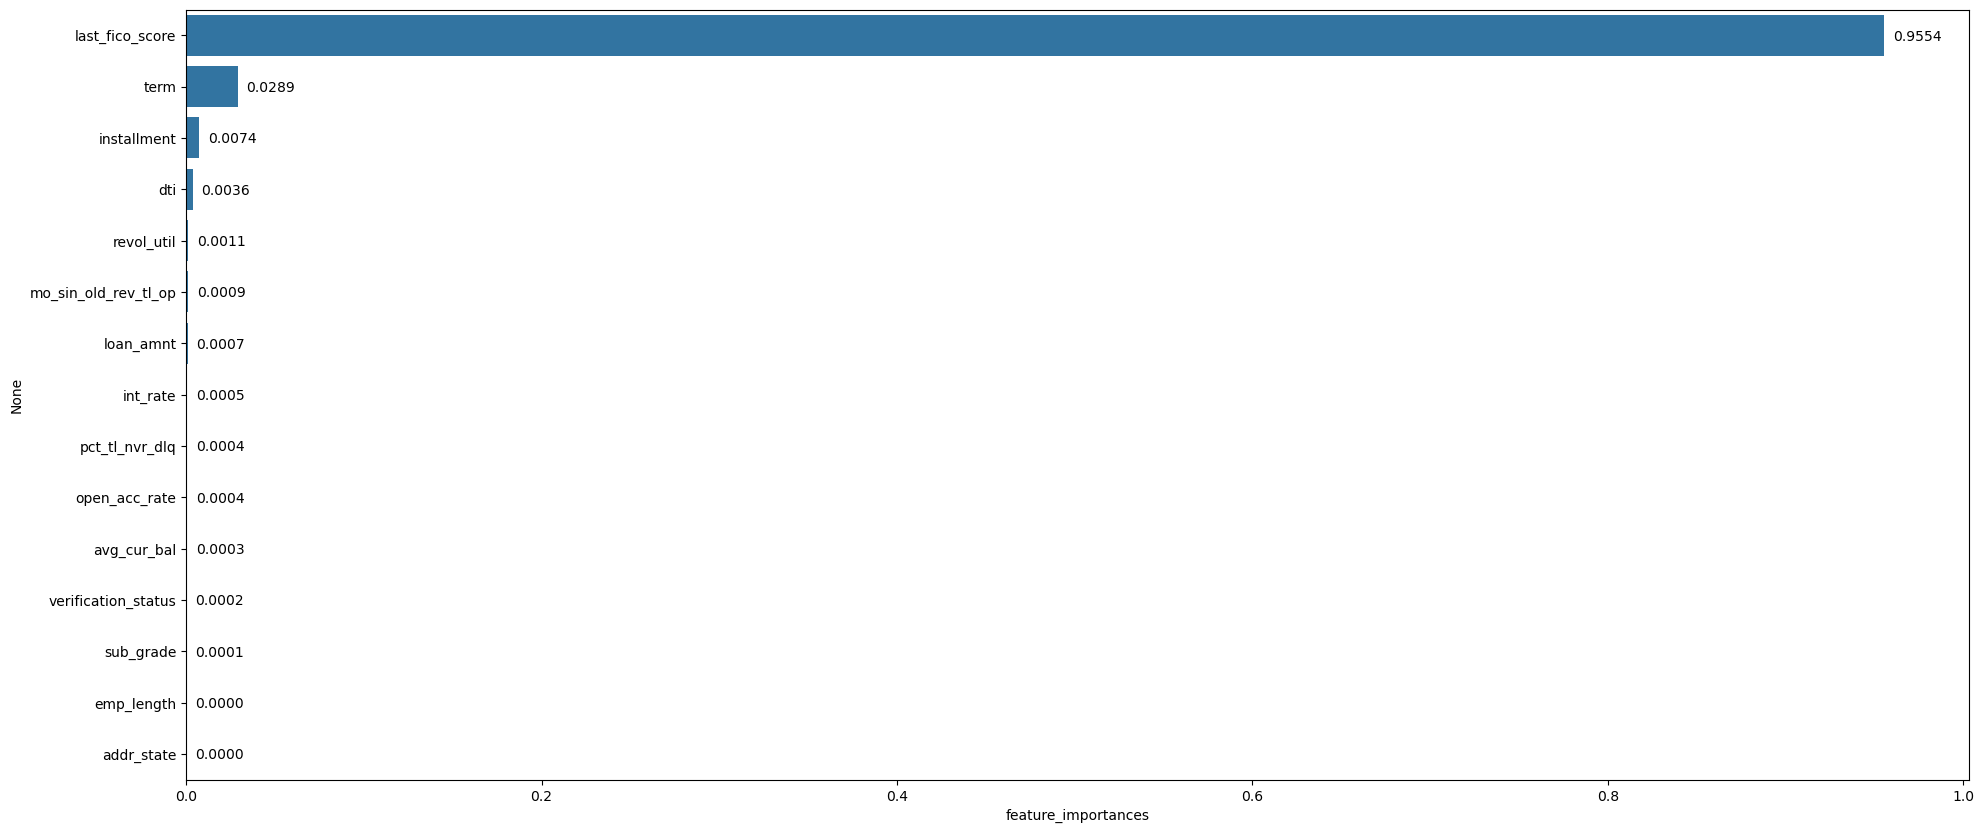

In [46]:
get_feature_importance(optimize_model, X_train_preprocessed, y_train_preprocessed, ["verification_status"])

### 2차 -> addr_state 제거

In [47]:
class FeatureSelect(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy = X_copy.drop(["addr_state", "mo_sin_rcnt_rev_tl_op"], axis=1)
        return X_copy

class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy["term"] = X_copy.term.str.extract("(\d+)").astype(np.float64)
        X_copy["open_acc_rate"] = (X_copy.open_acc / X_copy.total_acc * 100).round(1)
        X_copy["last_fico_score"] = X_copy[["last_fico_range_low", "last_fico_range_high"]].mean(axis=1).round()
        X_copy["installment"] = np.vectorize(lambda x, y, z: round((x * y * 0.01 / 12) * ((1 + y * 0.01 / 12) ** z) / (((1 + y * 0.01 / 12) ** z) - 1), 2))(X_copy.loan_amnt, X_copy.int_rate, X_copy.term)
        X_copy = X_copy.drop(["open_acc", "total_acc", "last_fico_range_low", "last_fico_range_high"], axis=1)
        return X_copy

In [48]:
preprocessing = Pipeline([("feature_select", FeatureSelect()), 
                          ("ordinal_encoder", OrdinalEncoder(mapping=[{"col": "sub_grade", 
                                                                       "mapping": {"F5": 0, "F4": 1, "F3": 2, "F2": 3, "F1": 4, 
                                                                                   "E5": 5, "E4": 6, "E3": 7, "E2": 8, "E1": 9, 
                                                                                   "D5": 10, "D4": 11, "D3": 12, "D2": 13, "D1": 14, 
                                                                                   "C5": 15, "C4": 16, "C3": 17, "C2": 18, "C1": 19, 
                                                                                   "B5": 20, "B4": 21, "B3": 22, "B2": 23, "B1": 24, 
                                                                                   "A5": 25, "A4": 26, "A3": 27, "A2": 28, "A1": 29}}, 
                                                                      {"col": "emp_length", 
                                                                       "mapping": {"< 1 year": 0, "1 year": 1, "2 year": 2, "3 year": 3, "4 year": 4, 
                                                                                   "5 year": 5, "6 year": 6, "7 year": 7, "8 year": 8, "9 year": 9, "10+ years": 10}}], 
                                                             cols=["sub_grade", "emp_length"])), 
                          ("onehot_encoder", OneHotEncoder(cols=["verification_status"], use_cat_names=True)), 
                          ("feature_engineer", FeatureEngineer()), 
                          ("under_resample", RandomUnderSampler(random_state=6))])

optimize_model = clone(tune_model)

In [49]:
X_train_preprocessed, y_train_preprocessed = preprocessing.fit_resample(X_train, y_train_transformed)
X_test_preprocessed, y_test_preprocessed = preprocessing[:4].transform(X_test), y_test_transformed

In [50]:
score_dict = cross_validate(optimize_model, X_train_preprocessed, y_train_preprocessed, scoring=["roc_auc", "recall"], n_jobs=-1, return_train_score=True)
get_score_df(score_dict, "최적화#2")

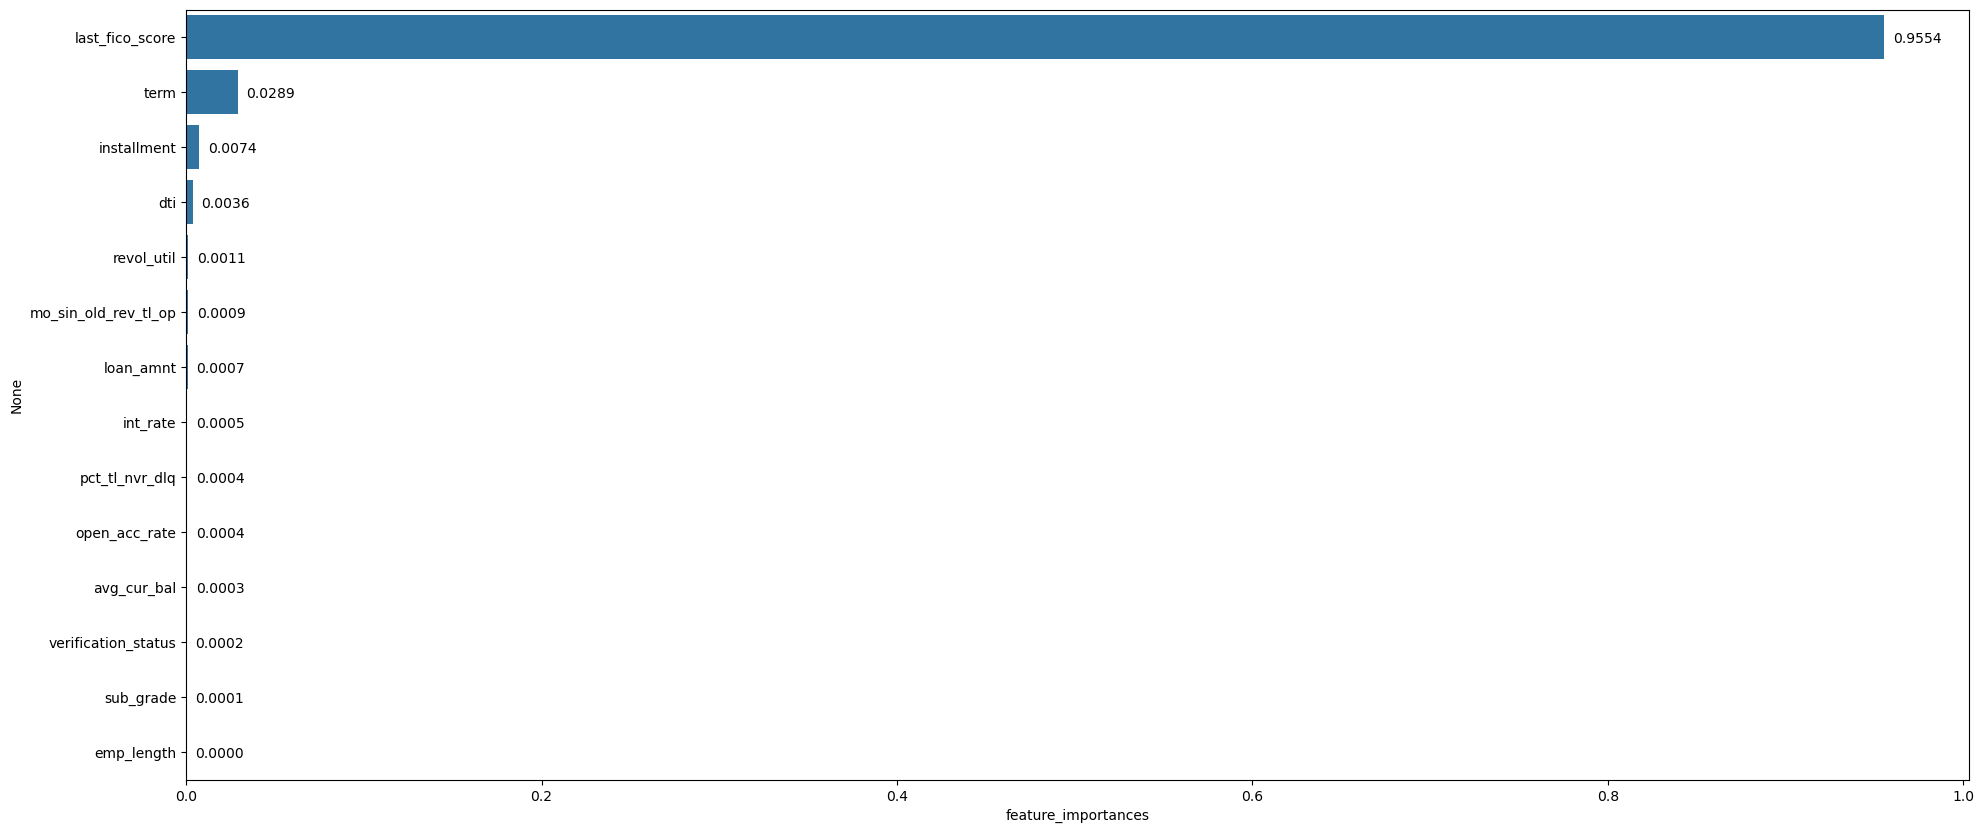

In [51]:
get_feature_importance(optimize_model, X_train_preprocessed, y_train_preprocessed, ["verification_status"])

### 3차 -> emp_length 제거

In [52]:
class FeatureSelect(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy = X_copy.drop(["emp_length", "addr_state", "mo_sin_rcnt_rev_tl_op"], axis=1)
        return X_copy

class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy["term"] = X_copy.term.str.extract("(\d+)").astype(np.float64)
        X_copy["open_acc_rate"] = (X_copy.open_acc / X_copy.total_acc * 100).round(1)
        X_copy["last_fico_score"] = X_copy[["last_fico_range_low", "last_fico_range_high"]].mean(axis=1).round()
        X_copy["installment"] = np.vectorize(lambda x, y, z: round((x * y * 0.01 / 12) * ((1 + y * 0.01 / 12) ** z) / (((1 + y * 0.01 / 12) ** z) - 1), 2))(X_copy.loan_amnt, X_copy.int_rate, X_copy.term)
        X_copy = X_copy.drop(["open_acc", "total_acc", "last_fico_range_low", "last_fico_range_high"], axis=1)
        return X_copy

In [53]:
preprocessing = Pipeline([("feature_select", FeatureSelect()), 
                          ("ordinal_encoder", OrdinalEncoder(mapping=[{"col": "sub_grade", 
                                                                       "mapping": {"F5": 0, "F4": 1, "F3": 2, "F2": 3, "F1": 4, 
                                                                                   "E5": 5, "E4": 6, "E3": 7, "E2": 8, "E1": 9, 
                                                                                   "D5": 10, "D4": 11, "D3": 12, "D2": 13, "D1": 14, 
                                                                                   "C5": 15, "C4": 16, "C3": 17, "C2": 18, "C1": 19, 
                                                                                   "B5": 20, "B4": 21, "B3": 22, "B2": 23, "B1": 24, 
                                                                                   "A5": 25, "A4": 26, "A3": 27, "A2": 28, "A1": 29}}], 
                                                             cols=["sub_grade"])), 
                          ("onehot_encoder", OneHotEncoder(cols=["verification_status"], use_cat_names=True)), 
                          ("feature_engineer", FeatureEngineer()), 
                          ("under_resample", RandomUnderSampler(random_state=6))])

optimize_model = clone(tune_model)

In [54]:
X_train_preprocessed, y_train_preprocessed = preprocessing.fit_resample(X_train, y_train_transformed)
X_test_preprocessed, y_test_preprocessed = preprocessing[:4].transform(X_test), y_test_transformed

In [55]:
score_dict = cross_validate(optimize_model, X_train_preprocessed, y_train_preprocessed, scoring=["roc_auc", "recall"], n_jobs=-1, return_train_score=True)
get_score_df(score_dict, "최적화#3")

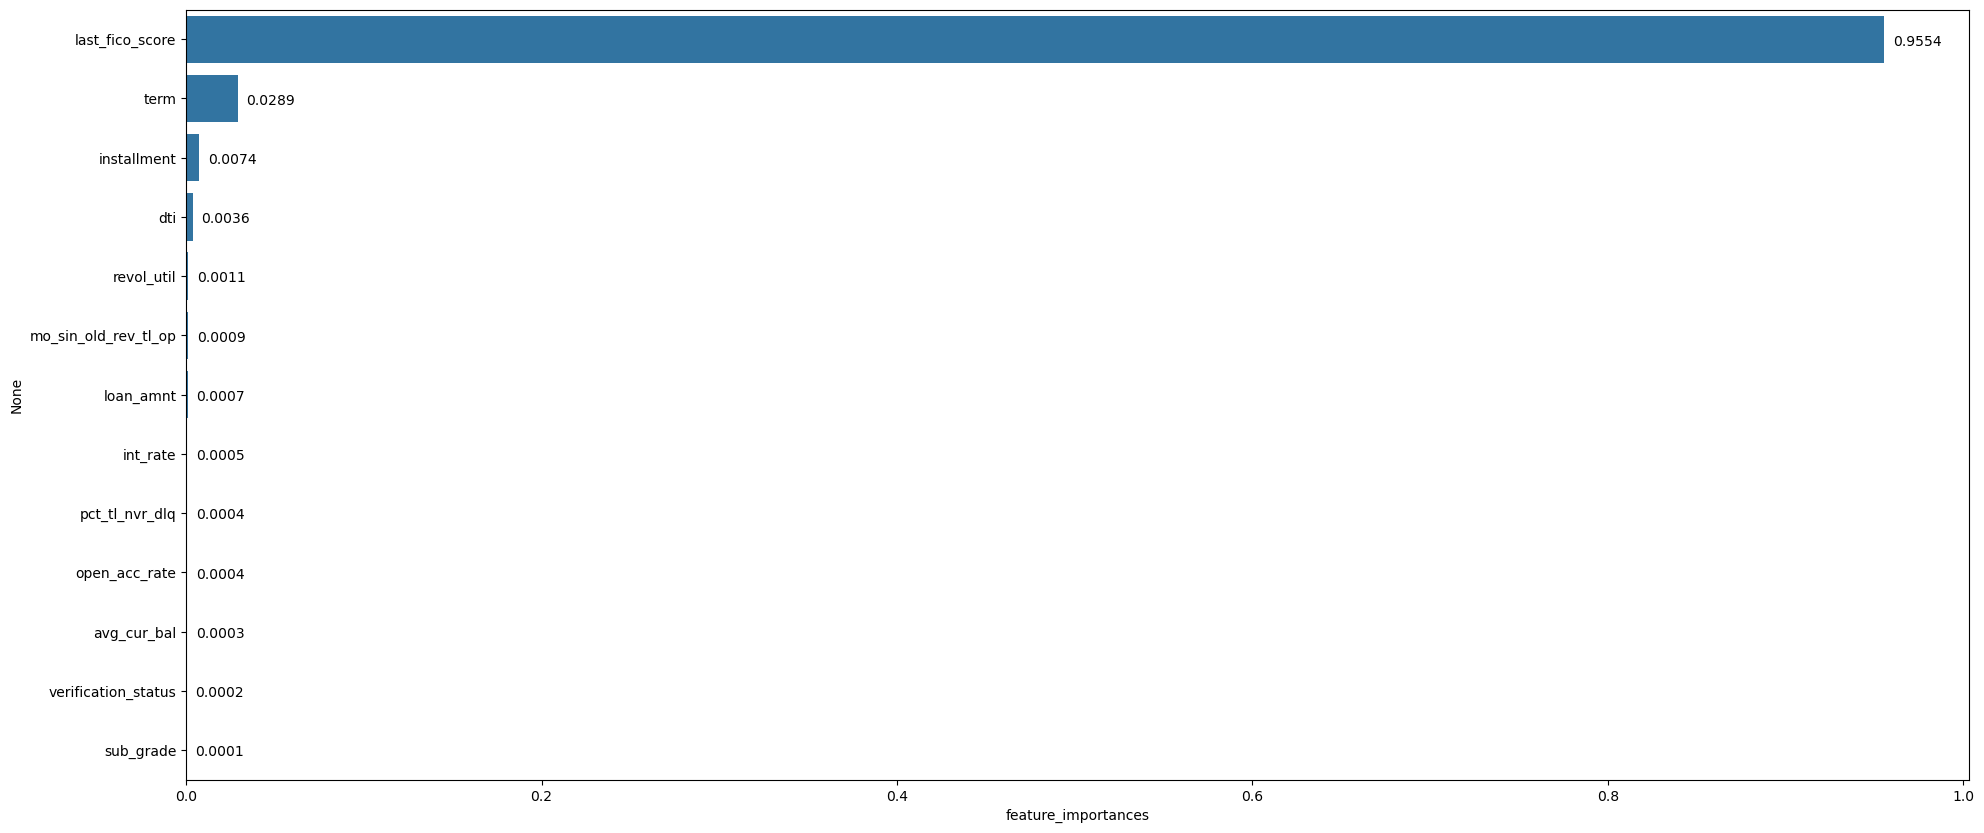

In [56]:
get_feature_importance(optimize_model, X_train_preprocessed, y_train_preprocessed, ["verification_status"])

### 결론

* 특성중요도가 0인 특성 3개에 대해서 해당 특성을 삭제 후 훈련을 진행해도 성능지표에 영향이 없다.
* 따라서 네가지 특성을 삭제하여 낭비되는 메모리를 잡고, 연산속도를 증가시킬 수 있다.

## 7. 모델 고도화를 위한 앙상블, 하이퍼파라미터 튜닝 진행

In [57]:
class FeatureSelect(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy = X_copy.drop(["emp_length", "addr_state", "mo_sin_rcnt_rev_tl_op"], axis=1)
        return X_copy

class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy["term"] = X_copy.term.str.extract("(\d+)").astype(np.float64)
        X_copy["open_acc_rate"] = (X_copy.open_acc / X_copy.total_acc * 100).round(1)
        X_copy["last_fico_score"] = X_copy[["last_fico_range_low", "last_fico_range_high"]].mean(axis=1).round()
        X_copy["installment"] = np.vectorize(lambda x, y, z: round((x * y * 0.01 / 12) * ((1 + y * 0.01 / 12) ** z) / (((1 + y * 0.01 / 12) ** z) - 1), 2))(X_copy.loan_amnt, X_copy.int_rate, X_copy.term)
        X_copy = X_copy.drop(["open_acc", "total_acc", "last_fico_range_low", "last_fico_range_high"], axis=1)
        return X_copy

In [58]:
preprocessing = Pipeline([("feature_select", FeatureSelect()), 
                          ("ordinal_encoder", OrdinalEncoder(mapping=[{"col": "sub_grade", 
                                                                       "mapping": {"F5": 0, "F4": 1, "F3": 2, "F2": 3, "F1": 4, 
                                                                                   "E5": 5, "E4": 6, "E3": 7, "E2": 8, "E1": 9, 
                                                                                   "D5": 10, "D4": 11, "D3": 12, "D2": 13, "D1": 14, 
                                                                                   "C5": 15, "C4": 16, "C3": 17, "C2": 18, "C1": 19, 
                                                                                   "B5": 20, "B4": 21, "B3": 22, "B2": 23, "B1": 24, 
                                                                                   "A5": 25, "A4": 26, "A3": 27, "A2": 28, "A1": 29}}], 
                                                             cols=["sub_grade"])), 
                          ("onehot_encoder", OneHotEncoder(cols=["verification_status"], use_cat_names=True)), 
                          ("feature_engineer", FeatureEngineer()), 
                          ("under_resample", RandomUnderSampler(random_state=6))])

boosting_model = AdaBoostClassifier(estimator=clone(tune_model), algorithm="SAMME", random_state=6)

bagging_model = BaggingClassifier(estimator=clone(tune_model), n_jobs=-1, random_state=6)

In [59]:
X_train_preprocessed, y_train_preprocessed = preprocessing.fit_resample(X_train, y_train_transformed)
X_test_preprocessed, y_test_preprocessed = preprocessing[:4].transform(X_test), y_test_transformed

### 7-1. 기본 앙상블 점수 확인

In [60]:
score_dict = cross_validate(boosting_model, X_train_preprocessed, y_train_preprocessed, scoring=["roc_auc", "recall"], n_jobs=-1, return_train_score=True)

In [61]:
get_score_df(score_dict, "앙상블(부스팅)")

In [62]:
score_dict = cross_validate(bagging_model, X_train_preprocessed, y_train_preprocessed, scoring=["roc_auc", "recall", "precision", "f1"], n_jobs=-1, return_train_score=True)

In [63]:
get_score_df(score_dict, "앙상블(배깅)")

### 7-2. 하이퍼파라미터 튜닝

In [65]:
# 아래의 그리드를 사용하여 pycaret에서 진행
boosting_grid = {"n_estimators": [50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300], 
                "learning_rate": [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]}

bagging_grid = {"n_estimators": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 
                 "max_samples": [0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0], 
                 "max_features": [0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]}

In [ ]:
boosting_tune_model = AdaBoostClassifier(estimator=clone(tune_model), n_estimators=300, learning_rate=0.03, algorithm="SAMME", random_state=6)
score_dict = cross_validate(boosting_tune_model, X_train_preprocessed, y_train_preprocessed, scoring=["roc_auc", "recall"], n_jobs=-1, return_train_score=True)
get_score_df(score_dict, "튜닝_앙상블(부스팅)")

In [ ]:
bagging_tune_model = BaggingClassifier(estimator=clone(tune_model), n_estimators=100, n_jobs=-1, random_state=6)
score_dict = cross_validate(bagging_tune_model, X_train_preprocessed, y_train_preprocessed, scoring=["roc_auc", "recall"], n_jobs=-1, return_train_score=True)
get_score_df(score_dict, "튜닝_앙상블(배깅)")

## 8. 다른 모델과 비교 (pycaret 활용)

## 9. 최종모델 선정 및 풀파이프라인 구축, 테스트점수 확인

### BaggingClassifier

#### 이유
1. 해석가능성 : 여러개의 기본 추정기를 평균화하는 방식으로 작동하여 모델의 동작이 상대적으로 간단하고 직관적이다.
2. 성능지표 : 다른 앙상블모델과 비교하였을때, 성능면에서 큰 차이가 나지 않는다.
3. 계산비용 : 계산비용이 적어 효율인 메모리관리가 가능하다.

### 9-1. 풀파이프라인 구축

In [ ]:
class FeatureSelect(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy = X_copy.drop(["emp_length", "addr_state", "mo_sin_rcnt_rev_tl_op"], axis=1)
        return X_copy

class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy["term"] = X_copy.term.str.extract("(\d+)").astype(np.float64)
        X_copy["open_acc_rate"] = (X_copy.open_acc / X_copy.total_acc * 100).round(1)
        X_copy["last_fico_score"] = X_copy[["last_fico_range_low", "last_fico_range_high"]].mean(axis=1).round()
        X_copy["installment"] = np.vectorize(lambda x, y, z: round((x * y * 0.01 / 12) * ((1 + y * 0.01 / 12) ** z) / (((1 + y * 0.01 / 12) ** z) - 1), 2))(X_copy.loan_amnt, X_copy.int_rate, X_copy.term)
        X_copy = X_copy.drop(["open_acc", "total_acc", "last_fico_range_low", "last_fico_range_high"], axis=1)
        return X_copy

In [ ]:
full_pipeline = Pipeline([("feature_select", FeatureSelect()), 
                          ("ordinal_encoder", OrdinalEncoder(mapping=[{"col": "sub_grade", 
                                                                       "mapping": {"F5": 0, "F4": 1, "F3": 2, "F2": 3, "F1": 4, 
                                                                                   "E5": 5, "E4": 6, "E3": 7, "E2": 8, "E1": 9, 
                                                                                   "D5": 10, "D4": 11, "D3": 12, "D2": 13, "D1": 14, 
                                                                                   "C5": 15, "C4": 16, "C3": 17, "C2": 18, "C1": 19, 
                                                                                   "B5": 20, "B4": 21, "B3": 22, "B2": 23, "B1": 24, 
                                                                                   "A5": 25, "A4": 26, "A3": 27, "A2": 28, "A1": 29}}], 
                                                             cols=["sub_grade"])), 
                          ("onehot_encoder", OneHotEncoder(cols=["verification_status"], use_cat_names=True)), 
                          ("feature_engineer", FeatureEngineer()), 
                          ("under_resample", RandomUnderSampler(random_state=6)), 
                          ("model", )])

full_pipeline.fit(X_train, y_train_transformed)

### 9-2. 테스트세트 성능확인

In [ ]:
y_train_pred = full_pipeline.predict(X_train)
y_train_score = full_pipeline.predict_proba(X_train)[:, 1]
y_test_pred = full_pipeline.predict(X_test)
y_test_score = full_pipeline.predict_proba(X_test)[:, 1]

In [ ]:
Styler(data=pd.DataFrame([roc_auc_score(y_train_transformed, y_train_score), roc_auc_score(y_test_transformed, y_test_score), recall_score(y_train_transformed, y_train_pred), recall_score(y_test_transformed, y_test_pred)], index=pd.MultiIndex([["ROC_AUC", "RECALL"], ["훈련", "테스트"]], [[0, 0, 1, 1], [0, 1, 0, 1]], name=["평가지표", "데이터"]), columns=["BEST_MODEL"]), 
       precision=4, 
       caption="최종모델 평가")

### 9-3. ROC Curve, 혼동행렬 확인

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(14, 14))
RocCurveDisplay.from_estimator(full_pipeline, X_test, y_test_transformed, name="Model", plot_chance_level=True, ax=ax[0, 0])
PrecisionRecallDisplay.from_estimator(full_pipeline, X_test, y_test_transformed, name="Model", ax=ax[0, 1])
ConfusionMatrixDisplay.from_estimator(full_pipeline, X_test, y_test_transformed, display_labels=["Fully Paid", "Charged Off"], ax=ax[1, 0], colorbar=False)
ConfusionMatrixDisplay.from_estimator(full_pipeline, X_test, y_test_transformed, normalize="true", display_labels=["Fully Paid", "Charged Off"], values_format=".1%", ax=ax[1, 1], colorbar=False)
ax[0, 0].set_title("ROC Curve")
ax[0, 1].set_title("PR Curve")
ax[1, 0].set_title("Confusion Matrix")
ax[1, 1].set_title("Confusion Matrix (normalize: true)")

ax[0, 0].set_xlabel("False Positive Rate (Positive Label: Charged Off)")
ax[0, 0].set_ylabel("True Positive Rate (Positive Label: Charged Off)")
ax[0, 1].set_xlabel("Recall (Positive Label: Charged Off)")
ax[0, 1].set_ylabel("Precision (Positive Label: Charged Off)")

ax[1, 1].set_ylabel(None)

# plt.savefig("img/model.png")
plt.show()

### 9-4. 모델 저장

In [ ]:
joblib.dump(full_pipeline, "model/final_model.pkl")